In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Patch
import seaborn as sns
import palettable as pal
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from descriptive_stats_table import descriptive_stats_table, overlay_tables
from dataframe_utils import data_get, vars_filter, vars_fill_nan

PATIENT = 'naion'

In [6]:
# Hyperparams

subject_colors_lut = {
'NAION Unilateral': '#BFD834',
'NAION Bilateral': '#2AA10F',
'NAION': '#2AA10F',
'ODD-NAION': '#4242ff',
'Control': '#222222',
'ODD': '#C576F6'}

INDEPENDENT = ['group', 'group_binary']
IDENTIFICATION = ['id', 'months', 'visit_no']
FIGURE_DIR = '1215'

independent_vars = 'group' if PATIENT == 'naion' else 'group_binary'

### Import data

In [4]:

def cmap_hex_linspace(cmap, n_classes, palplot=False):
    new_cmap = plt.get_cmap(cmap)
    new_cmap_hex = []
    for i in np.linspace(0,255,n_classes+1):
        rgba = new_cmap(int(i))
        new_cmap_hex.append(colors.rgb2hex(rgba))
    if palplot:
        sns.palplot(new_cmap_hex)
    return new_cmap_hex

patient_group = PATIENT
independent_vars = INDEPENDENT
identification_vars = IDENTIFICATION

# Filter out unwanted data

data = data_get('1209-%s.csv' % patient_group)
print('Eyes at the start   -> %d' % data.shape[0])

data = data[~(data['months']<=6)]
print('Eyes with >6 months -> %d' % data.shape[0])

data = data[data['good']==1]
print("Eyes with good data -> %d" % data.shape[0])

dependent_vars = [d_var for d_var in data.columns for this_str in ['mean', 'oct', 'fpf', 'vf', 'hvf', 'mac_ret', 'disc_ret'] if d_var.startswith(this_str)]

data_variables = independent_vars + identification_vars + dependent_vars
groupby_variables = independent_vars + ['id', 'visit_no']

data = data.groupby(groupby_variables)[dependent_vars].mean().reset_index()
''' This reduces nrows from 58 to 55, no real diff. I suspect there's a repeat in there somewhere. '''

print('Final # Eyes        -> %d' % data['id'].nunique())

Eyes at the start   -> 103
Eyes with >6 months -> 75
Eyes with good data -> 58
Final # Eyes        -> 57


## Clustermap


<Figure size 640x480 with 0 Axes>

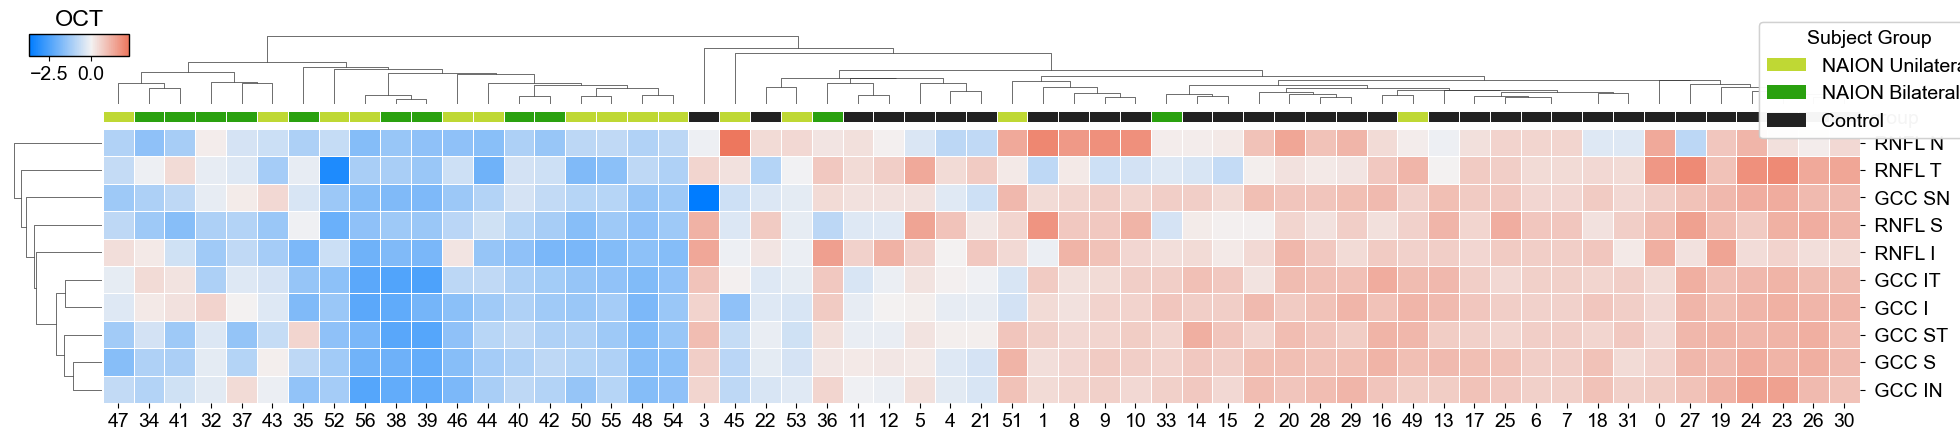

<Figure size 640x480 with 0 Axes>

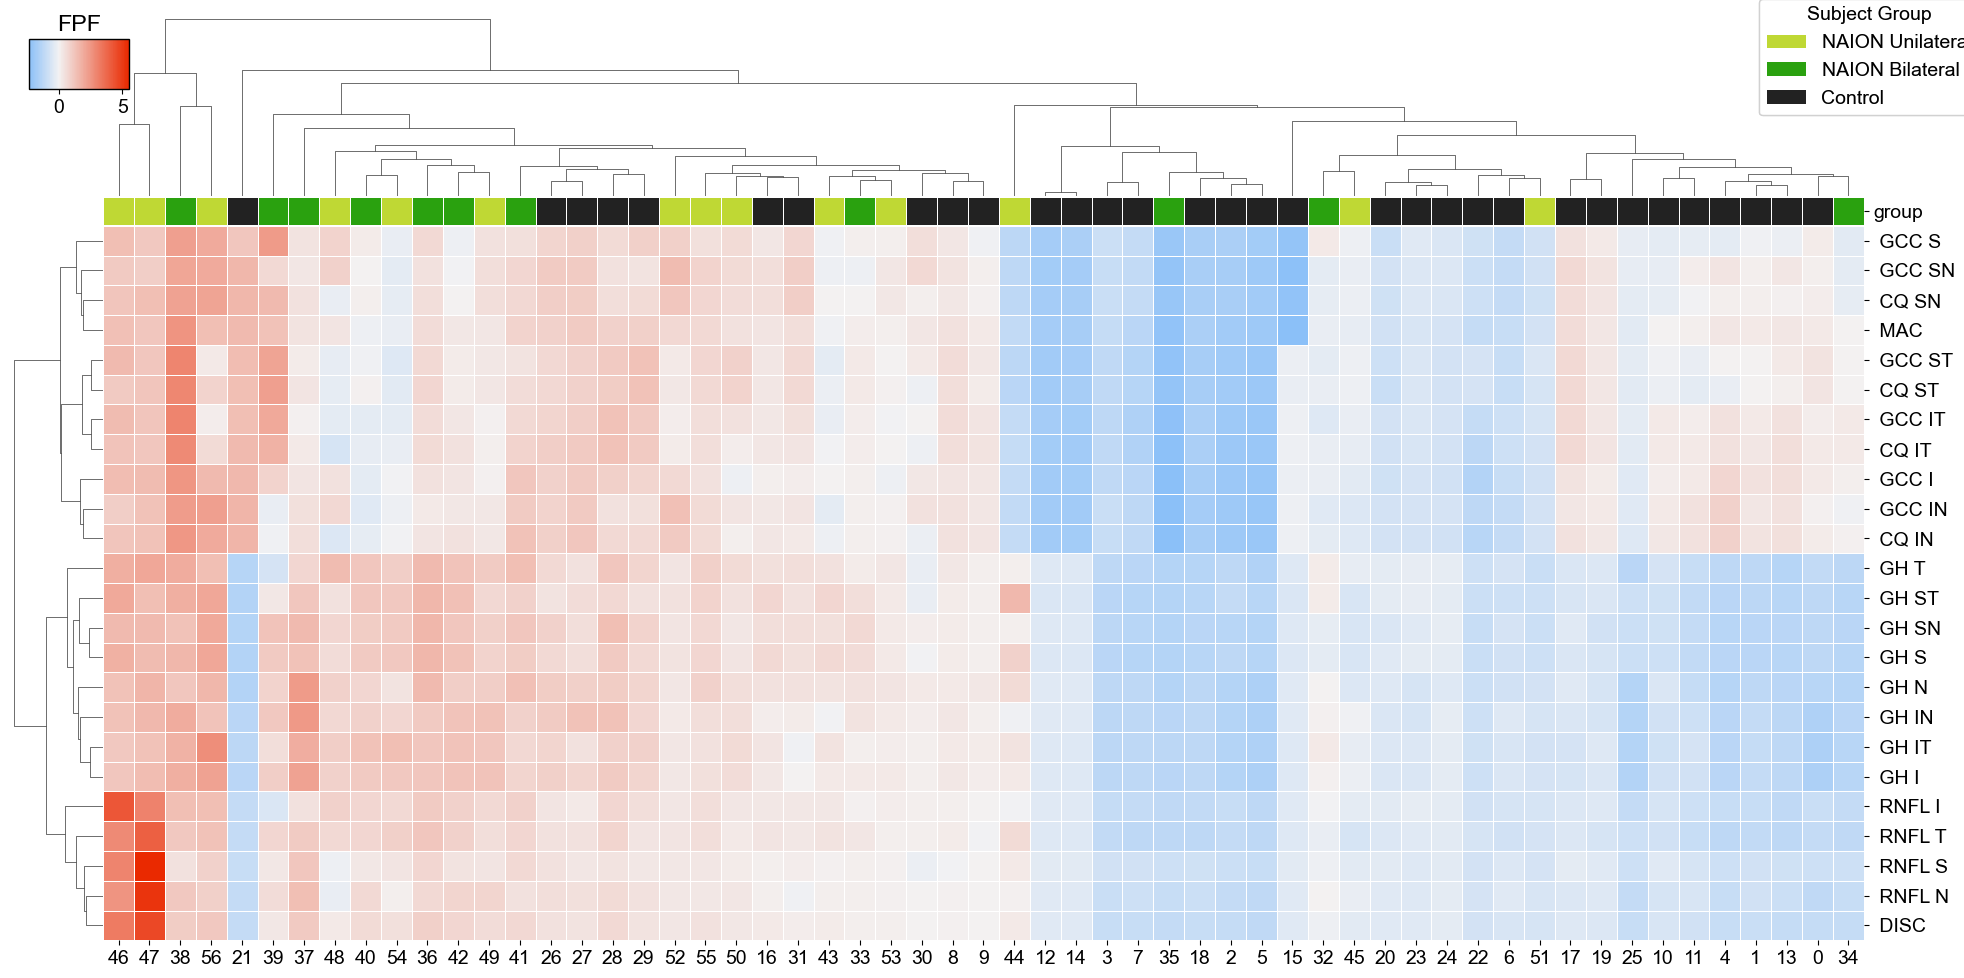

In [7]:
matplotlib.rcParams["font.family"]      = "sans-serif"
matplotlib.rcParams["font.sans-serif"]  = "Arial"
matplotlib.rcParams["font.size"]        = 14

for sub_datatype in ['oct', 'fpf']:

    subgroup_dependent_vars = list(data.filter(regex=sub_datatype))
    subgroup_vars = subgroup_dependent_vars + [independent_vars]
    subgroup_data = data[subgroup_vars].copy()
    subgroup_data = vars_fill_nan(
        subgroup_data, d_vars=subgroup_dependent_vars, i_vars=independent_vars)
    
    # Standard scale the data
    scaler = StandardScaler()
    subgroup_data[subgroup_dependent_vars] = scaler.fit_transform(
        subgroup_data[subgroup_dependent_vars])

    # Get colormap
    cmap = sns.diverging_palette(250, 22, s=160, as_cmap=True)

    # Row/column colors
    var = independent_vars
    clm_groups = subgroup_data[var].unique().tolist()
    clm_lut = {k:v for k,v in subject_colors_lut.items() if k in subgroup_data[independent_vars].unique().tolist()}
    clm_hex = subject_colors_lut.values()
    clm_colors = subgroup_data[var].map(clm_lut)

    f_height = subgroup_data.shape[1] * .4

    # Generate clustermap
    f = plt.figure()
    
    g = sns.clustermap(
        subgroup_data[subgroup_dependent_vars].T, 
        cmap=cmap,
        center=0, 
        figsize=(20,f_height), 
        col_colors=clm_colors,
        dendrogram_ratio=(.05,.2), 
        cbar_kws=dict(orientation='horizontal'),
        linewidth=.5)
    
    # Legend
    handles = [Patch(facecolor=clm_lut[name])for name in clm_lut]
    legend = plt.legend(handles, clm_lut, title='Subject Group', ncol=1, bbox_to_anchor=(1,1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    plt.gca().add_artist(legend)
    
    # Colorbar
    spinecolor = 'k'
    spinewidth = 1
    g.ax_cbar.set_position((.02,.9,.05,.05))
    g.ax_cbar.set_title(sub_datatype.upper())

    for spine in g.ax_cbar.spines:
        g.ax_cbar.spines[spine].set_color(spinecolor)
        g.ax_cbar.spines[spine].set_linewidth(spinewidth)
    
    # Axis labels
    axes_object = g.ax_heatmap
    ticklabels = axes_object.get_yticklabels()
    ticklabels = [t.get_text().replace("_"," ")for t in ticklabels]
    ticklabels = [t.replace(sub_datatype,"").upper() for t in ticklabels]
    
    axes_object.set_yticklabels(ticklabels)
    plt.title(sub_datatype.upper())

    plt.savefig('../output/%s/%s_%s_clustermap.pdf' % (
        FIGURE_DIR,
        PATIENT,
        sub_datatype))
    plt.show()

Get data for ANOVA analysis later...

In [8]:
whole_variables = [
    'hvf_mean_deviation', 'mean_rnfl', 'fpf_disc', 'mean_gcc', 'fpf_mac']
subgroup_variables = whole_variables + [independent_vars, 'id']
subgroup_data_wide = data[subgroup_variables].copy()
subgroup_data_wide.to_csv('../data/1209-%s-anova.csv' % PATIENT)

subgroup_data = pd.melt(subgroup_data_wide, id_vars=['id', independent_vars], value_vars=whole_variables)

display(subgroup_data.head())

,id,group,variable,value
0,217_OD,Control,hvf_mean_deviation,2.110000
1,281_OD,Control,hvf_mean_deviation,0.300000
2,302_OS,Control,hvf_mean_deviation,0.030000
3,303_OS,Control,hvf_mean_deviation,-3.570000
4,305_OD,Control,hvf_mean_deviation,-0.558333


Strip plots for the ANOVA analysis

<Figure size 640x480 with 0 Axes>

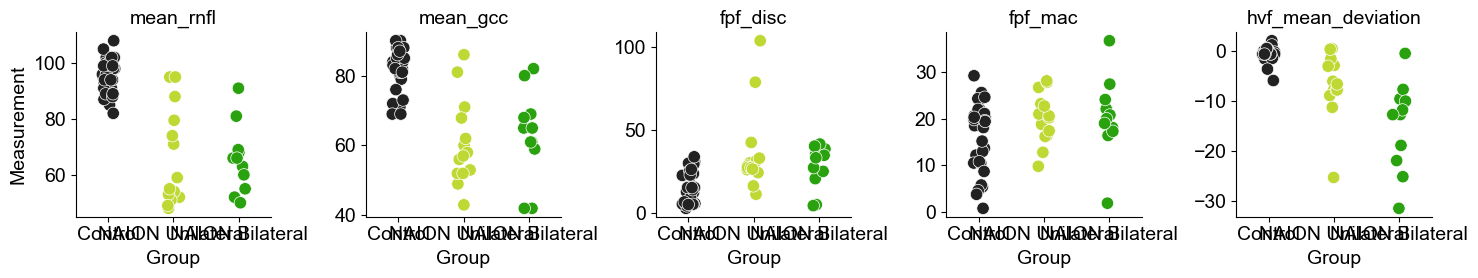

In [9]:
clm_groups = subgroup_data[independent_vars].unique().tolist()
clm_lut = subject_colors_lut
clm_hex = subject_colors_lut.values()
clm_colors = subgroup_data[independent_vars].map(clm_lut)

matplotlib.rcParams["font.family"]      = "sans-serif"
matplotlib.rcParams["font.sans-serif"]  = "Arial"
matplotlib.rcParams["font.size"]        = 14

if PATIENT=='naion':
    hue_order = ['Control', 'NAION Unilateral', 'NAION Bilateral']
    catplot_data = subgroup_data.sort_values("group", key=np.vectorize(hue_order.index))
else:
    catplot_data = subgroup_data

f = plt.figure()
g = sns.catplot(
    data=catplot_data,
    x=independent_vars,
    y='value',
    col='variable',
    col_order=['mean_rnfl', 'mean_gcc', 'fpf_disc', 'fpf_mac', 'hvf_mean_deviation'],
    hue=independent_vars,
    linewidth=.5,
    edgecolor='w',
    s=80,
    sharey=False,
    palette=clm_lut,
    height=3,   # 2.25
    aspect=1.,  #.9
)
(g.set_axis_labels("Group", "Measurement")
    .set_titles("{col_name}")
    .tight_layout(w_pad=.8, h_pad=.8)
    )

plt.savefig('../output/%s/%s_%s_stripplot.pdf' % (
    FIGURE_DIR,
    PATIENT,
    sub_datatype))

plt.show()

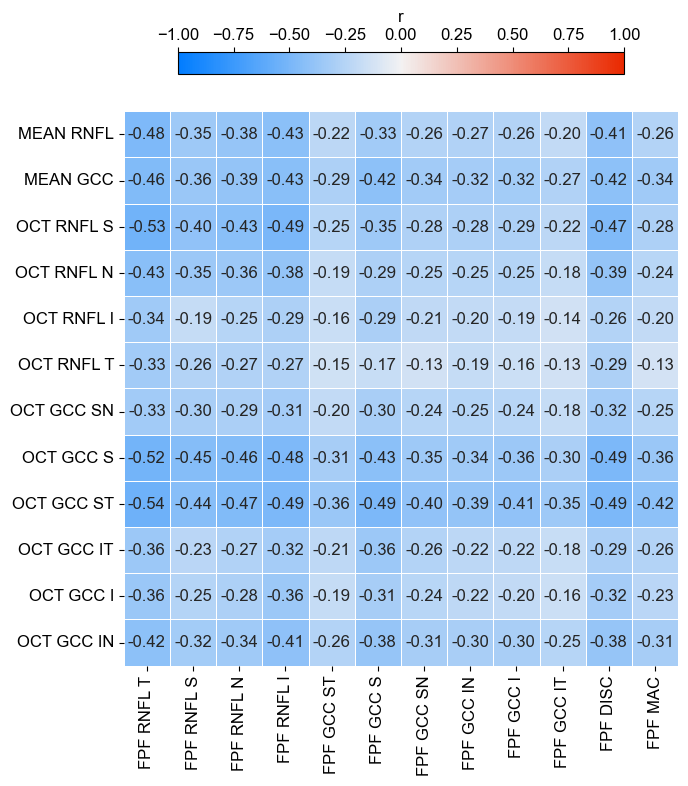

In [10]:
# Group sectors
data_copy = vars_filter(data.copy(), ['gh_', 'cq_'])
subgroup_dependent_vars = [col for col in data_copy.columns if col.startswith('oct') or col.startswith('fpf') or col.startswith('mean') ]
subgroup_vars = subgroup_dependent_vars + [independent_vars, 'id']
subgroup_data = data_copy[subgroup_vars].copy()
subgroup_data = vars_filter(subgroup_data, ['gh_', 'cq_'])

data_corrmatrix = subgroup_data[subgroup_dependent_vars].corr()

unique_c = [col for col in data_corrmatrix.columns if col.startswith('fpf')]
unique_i = [idx for idx in data_corrmatrix.index if idx.startswith('oct') or idx.startswith('mean')]
data_corrmatrix_unique = data_corrmatrix.loc[unique_c, unique_i]

fsize = data_corrmatrix_unique.shape[0] * .8

matplotlib.rcParams["font.family"]      = "sans-serif"
matplotlib.rcParams["font.sans-serif"]  = "Arial"
matplotlib.rcParams["font.size"]        = 12

f = plt.figure(figsize=(fsize,fsize))

g = sns.heatmap(
    data_corrmatrix_unique.T,
    vmin=-1,
    vmax=1,
    cmap=cmap,
    annot=True,
    fmt='.2f',
    square=True,
    cbar=False,
    linewidth=.5)
    
# axes object is g since this is a heatmap
ticklabels = g.get_xticklabels()
ticklabels = [t.get_text().replace("_"," ").upper() for t in ticklabels]
g.set_xticklabels(ticklabels)

ticklabels = g.get_yticklabels()
ticklabels = [t.get_text().replace("_"," ").upper() for t in ticklabels]
g.set_yticklabels(ticklabels)

spinecolor = 'k'
spinewidth = 1

cbar = g.figure.colorbar(
    g.collections[0],
    fraction=.2,
    shrink=.6,
    location='top',
    label='r')

plt.savefig('../output/%s/%s_corr_heatmap.pdf' % (
    FIGURE_DIR,
    PATIENT))

<Figure size 640x480 with 0 Axes>

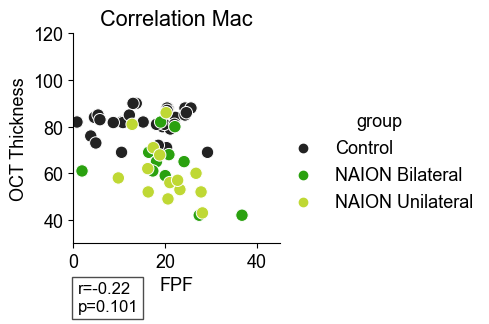

<Figure size 640x480 with 0 Axes>

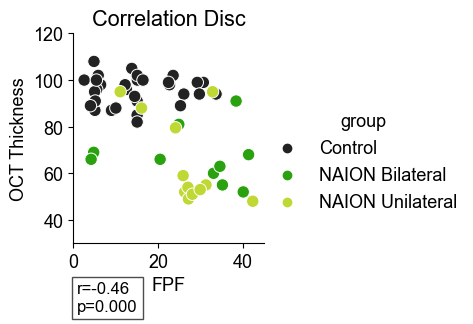

In [20]:
matplotlib.rcParams["font.family"]      = "sans-serif"
matplotlib.rcParams["font.sans-serif"]  = "Arial"
matplotlib.rcParams["font.size"]        = 13

whole_variables = ['mean_rnfl', 'mean_gcc', 'fpf_disc', 'fpf_mac']
corr_variables = whole_variables + [independent_vars, 'id']
fpf_oct = data[corr_variables]
fpf_oct_corr = fpf_oct[whole_variables].corr()

for structure, var_set in {'Mac':['fpf_mac', 'mean_gcc'], 'Disc':['fpf_disc', 'mean_rnfl']}.items():

    fpf_var, oct_var = var_set[0], var_set[1]

    f = plt.figure()

    #fpf_oct = fpf_oct[fpf_oct['fpf_disc'] < 75]

    g = sns.relplot(
        data=fpf_oct, 
        x=fpf_var, 
        y=oct_var,
        hue=independent_vars,
        s=80,
        facet_kws={'sharey':False},
        height=3,   # 2.25
        palette=clm_lut,
        aspect=1.1,  #.9
        )
    d1 = fpf_oct[fpf_var].values
    d2 = fpf_oct[oct_var].values

    r,p = stats.spearmanr(d1,d2, nan_policy='omit',alternative='two-sided')
    alpha = 0.05
    # check bonferroni p values
    results_str = 'r=%.2f\np=%.3f' % (r,p)
    results = [np.round(r,2), np.round(p,3), results_str]
    props = dict(boxstyle='square', facecolor='white', alpha=.7)

    plt.text(.9,.9, results_str, fontsize=12, bbox=props)
    plt.title('Correlation %s' % structure)
    plt.xlim((0,45))
    plt.ylim(30, 120)
    plt.xlabel('FPF')
    plt.ylabel('OCT Thickness')

    plt.savefig('../output/%s/%s_%s_relplot.pdf' % (
    FIGURE_DIR,
    PATIENT,
    fpf_var.split('_')[1]))